# House Prices

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import d2l.torch as d2l

### 数据准备

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
print(train_data.shape, test_data.shape)

(1460, 81) (1459, 80)


`train_data.iloc[:,1:-1]` 不带有最后一列, 最后一列是房价, `test_data` 是最后要预测的房价

In [3]:
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:]))

`all_features.dtypes` 是一个 `Series` 类, `name` 为 `index` , `dtype` 为 `value`

In [4]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

对数据进行标准化, $x = \dfrac{x-\mu}{\sigma}$, 让所有的特征都是 $0$ 均值, 单位方差, 对于 $nan$ 的数据本来是应该赋平均值, 现在就只需要赋值 $0$ 就可以了

In [5]:
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean())/ x.std())
all_features[numeric_features] = all_features[numeric_features].fillna(0)

把数据中的文本进行标签化, 设置 $dummy\_na$ 设置为 $False$ 即不忽略 $nan$ 并且将其当作一类来处理

In [6]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

将数据转换成 $tensor$

In [7]:
num_train = train_data.shape[0]
train_features = torch.tensor(all_features[:num_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[num_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1), dtype=torch.float32)

### 训练

In [27]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
def get_net(drop_out = 0.3):
    net = nn.Sequential(
        nn.Linear(in_features, 256),nn.ReLU(),
        nn.Dropout(drop_out),
        nn.Linear(256,128),nn.ReLU(),
        nn.Dropout(drop_out),
        nn.Linear(128,64),nn.ReLU(),
        nn.Dropout(drop_out),
        nn.Linear(64,30),nn.ReLU(),
        nn.Linear(30,8),nn.ReLU(),
        nn.Linear(8,1)
    )
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

在以前的训练过程中 :  $\operatorname{Loss}=\left\| y - \hat{y}\right\| ^ 2$ , 然而在房价当中, 我们更加关心的使相对数量, 而不是绝对数量, 即 $\dfrac{y-\hat{y}}{y}$ , 因此定义新的损失函数

$$
\operatorname{Loss} = \sqrt{\dfrac{1}{n}\sum_{i=1}^n(\log y_i-\log\hat{y_i})^2}
$$

常数就不要了, 相除变为求 $\log$

`torch.clamp(net(features), 1, float('inf'))` 将 `net(features)` 里面的值限制到 $[1,inf]$之间, 小于 $1$ 的数值变成 $1$ , 是为了数据的稳定性

In [9]:
def log_RMSE(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

训练函数

In [10]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_loss, test_loss = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_loss.append(log_RMSE(net, train_features, train_labels))
        if test_labels is not None:
            test_loss.append(log_RMSE(net, test_features, test_labels))
    return train_loss, test_loss

### K 折交叉验证

在 $K$ 折交叉验证中返回第 $i$ 折的数据, 选择第 $i$ 个切片作为验证数据, 其余部分作为训练数据

`slice` 函数返回一个类似于 `iter` 的东西, 方便下标索引, `slice(l,r)` 返回 $[l, r)$ 的索引

In [11]:
def get_k_fold_data(k, i, X, y):
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

使用 $k$ 折交叉验证的目的是在数据少的情况下, 对超参数进行一个调整

In [12]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size, drop_out):
    train_loss_sum, valid_loss_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(drop_out)
        train_loss, valid_loss = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_loss_sum += train_loss[-1]
        valid_loss_sum += valid_loss[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_loss, valid_loss], xlabel='epoch', ylabel='RMSE', xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'折 {i+1}, 训练 log RMSE {float(train_loss[-1]):f}, 验证 log RMSE {float(valid_loss[-1]):f}')
    return train_loss_sum/k, valid_loss_sum/k

折 1, 训练 log RMSE 0.130423, 验证 log RMSE 0.141612
折 2, 训练 log RMSE 0.125796, 验证 log RMSE 0.149237
折 3, 训练 log RMSE 0.126088, 验证 log RMSE 0.150374
折 4, 训练 log RMSE 0.130865, 验证 log RMSE 0.129644
折 5, 训练 log RMSE 0.121887, 验证 log RMSE 0.159074
5 折验证, 平均训练 log RMSE 0.127012, 平均验证 log RMSE 0.145988


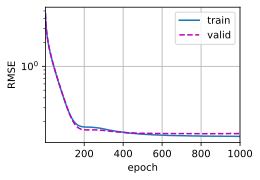

In [31]:
k, batch_size = 5, 64
num_epochs, learning_rate, weight_decay, drop_out = 1000, 2, 0.04, 0.3
train_loss, valid_loss = k_fold(k, train_features, train_labels, num_epochs, learning_rate, weight_decay, batch_size, drop_out)
print(f'{k} 折验证, 平均训练 log RMSE {float(train_loss):f}, 平均验证 log RMSE {float(valid_loss):f}')

### 预测

我们已经通过 $k$ 折交叉验证得到了合理的超参数值, 接下来就用这个值在整个训练集上进行预测

In [ ]:
def train_and_predict(train_features, test_features, train_labels, test_data, num_epochs, learning_rate, weight_decay, batch_size, drop_out):
    net = get_net(drop_out)
    train_loss, _ = train(net, train_features, train_labels, None, None, num_epochs, learning_rate, weight_decay, batch_size)
    d2l.plot(np.arange(1,num_epochs+1), [train_loss], xlabel='epochs', ylabel='log RMSE', xlim=[1,num_epochs], yscale='log')
    print(f'训练log rmse: {float(train_loss[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse: 0.129029


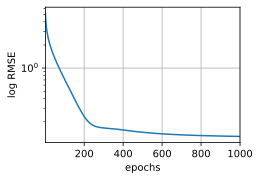

In [ ]:
train_and_predict(train_features, test_features, train_labels, test_data, num_epochs, learning_rate, weight_decay, batch_size, drop_out)